In [1]:
import warnings
from xml.etree.ElementInclude import include
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from statistics import mean
import numpy as np
import statsmodels.api as sm


import matplotlib
plt.style.use('ggplot')

matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

import seaborn as sns



In the current dataset you’re expected to track the user’s engagement using the following engagement metrics: 
sessions frequency 
the duration of the session 
the sessions total traffic (download and upload (bytes))???
How do we solve this problem?
- we recognise a user as MSISDN/NUMBER
- group the users based on the data used on the apps,
- determine what parameters can help portray engagement


In [2]:
df = pd.read_csv("../data/telcom.csv")

In [3]:
app_df = pd.DataFrame({'customer':df['MSISDN/Number'],
                      'sessions_frequency':df['Bearer Id'],
                      'duration':df['Dur. (ms)']})
app_df['social_media_data'] = df['Social Media DL (Bytes)'] + df['Social Media UL (Bytes)']
app_df['google_data'] = df['Google DL (Bytes)'] + df['Google UL (Bytes)'] 
app_df['email_data'] = df['Email DL (Bytes)'] + df['Email UL (Bytes)'] 
app_df['youtube_data'] = df['Youtube DL (Bytes)'] + df['Youtube UL (Bytes)']
app_df['netflix_data'] = df['Netflix DL (Bytes)'] + df['Netflix UL (Bytes)']
app_df['gaming_data'] = df['Gaming DL (Bytes)'] + df['Gaming UL (Bytes)'] 
app_df['other_data'] = df['Other DL (Bytes)'] + df['Other UL (Bytes)']
app_df['total_data'] = df['Total UL (Bytes)'] + df['Total DL (Bytes)']

In [4]:
app_df.head()

,customer,sessions_frequency,duration,social_media_data,google_data,email_data,youtube_data,netflix_data,gaming_data,other_data,total_data
0,3.366496e+10,1.311450e+19,1823652.0,1570185.0,2905912.0,3701304.0,18355943.0,17855187.0,292426453.0,180558843.0,345629377.0
1,3.368185e+10,1.311450e+19,1365104.0,1933278.0,4414096.0,937385.0,39359124.0,35565545.0,609920783.0,541959383.0,707185356.0
2,3.376063e+10,1.311450e+19,1361762.0,1726277.0,10229119.0,3363124.0,34425237.0,23751202.0,229980251.0,414908351.0,307690973.0
3,3.375034e+10,1.311450e+19,1321509.0,657493.0,11811761.0,2070983.0,36534765.0,15092588.0,810387875.0,761837216.0,889352748.0
4,3.369980e+10,1.311450e+19,1089009.0,912788.0,7748843.0,2110349.0,34222253.0,17539799.0,531237049.0,564619822.0,607681403.0


In [5]:
def aggregation_cols(df,col_1,col_2,trim=False):
    
    grouped = df.groupby(col_1).agg({col_2: [min, max, mean]}) 
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    if trim:
        return grouped.describe()
    return grouped

In [6]:
duration_aggregation = aggregation_cols(app_df,'customer','duration')
top_customers_duration = duration_aggregation.sort_values(by='duration_max', ascending=False)
top_customers_duration.head(10)

,duration_min,duration_max,duration_mean
customer,,,
3.362578e+10,216668.0,1859336.0,1.091397e+06
3.366496e+10,259557.0,1823652.0,1.041604e+06
3.376355e+10,86399.0,1679813.0,8.718988e+05
3.366926e+10,1573420.0,1573420.0,1.573420e+06
3.366172e+10,1480875.0,1480875.0,1.480875e+06
3.360750e+10,1474663.0,1474663.0,1.474663e+06
3.366915e+10,226538.0,1468680.0,7.659867e+05
3.366284e+10,146548.0,1392232.0,7.349189e+05
3.369870e+10,1036806.0,1382408.0,1.209607e+06


In [7]:
sessions_aggregation = aggregation_cols(app_df,'customer','sessions_frequency')
top_customers_session = sessions_aggregation.sort_values(by='sessions_frequency_max', ascending=False)
top_customers_session.head(10)

,sessions_frequency_min,sessions_frequency_max,sessions_frequency_mean
customer,,,
3.366539e+10,1.318650e+19,1.318650e+19,1.318650e+19
3.361611e+10,1.311450e+19,1.318650e+19,1.315050e+19
3.366683e+10,1.318650e+19,1.318650e+19,1.318650e+19
3.366860e+10,1.304240e+19,1.318650e+19,1.311448e+19
3.363277e+10,1.318650e+19,1.318650e+19,1.318650e+19
3.365941e+10,1.318650e+19,1.318650e+19,1.318650e+19
3.366603e+10,1.318650e+19,1.318650e+19,1.318650e+19
3.365869e+10,1.318650e+19,1.318650e+19,1.318650e+19
3.366671e+10,1.318650e+19,1.318650e+19,1.318650e+19


In [8]:
traffic_aggregation = aggregation_cols(app_df,'customer','total_data')
top_customers_traffic = traffic_aggregation.sort_values(by='total_data_max', ascending=False)
top_customers_traffic.head(10)

,total_data_min,total_data_max,total_data_mean
customer,,,
3.367492e+10,917345508.0,955984776.0,936665142.0
3.366469e+10,129426890.0,952641334.0,530740848.0
3.366855e+10,461875236.0,952307464.0,759167871.5
3.365881e+10,292423647.0,951775502.0,622952450.0
3.366783e+10,950760661.0,950760661.0,950760661.0
3.361083e+10,493831975.0,949987157.0,721909566.0
3.360667e+10,330304121.0,949598255.0,639951188.0
3.366261e+10,949292055.0,949292055.0,949292055.0
3.366205e+10,949172538.0,949172538.0,949172538.0


concerning the duration, we realize that the top 10 customers range from 1800-1300 seconds
concerning the sessions, we realize that they remain consistent at 1.318650e+19 
concerning the data we realize that they range from 955984776-948809765 bytes of data

#### task 2Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement
we can do this;
-generate pipelines
-transform data
-run k-means

In [9]:
def generate_pipeline(type_="numeric",x=1):
    pipeline = None
    if type_ == "numeric":
        pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='mean')),
            ('scale', MinMaxScaler())
        ])
    elif type_ == "categorical":
        pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])
    else:
        pipeline = np.zeros(x)
    return pipeline

In [10]:
def store_features(df,type_,value):
    features = [None]
    if type_ == "numeric":
        features = df.select_dtypes(include=value).columns.tolist()
    elif type_ == "categorical":
        features = df.select_dtypes(exclude=value).columns.tolist()
    return features

In [11]:
def generate_transformation(pipeline,df,type_,value):
    transformation = None
    if type_=="numeric":
        transformation=pipeline.fit_transform(df.select_dtypes(include=value))
    elif type_ == "categorical":
        transformation=pipeline.fit_transform(df.select_dtypes(exclude=value))
    return transformation

In [12]:
def frame_transforms(transform,features):
    return pd.DataFrame(transform,columns=features)

In [13]:
application_pipeline = generate_pipeline(type_="numeric")
df_to_transform = app_df[app_df.columns.to_list()[1:]]
application_transformation = generate_transformation(application_pipeline,df_to_transform,"numeric","number")
application_transformed_df = frame_transforms(application_transformation,df_to_transform.columns)
application_transformed_df['customer'] = app_df['customer']
application_transformed_df.head()

,sessions_frequency,duration,social_media_data,google_data,email_data,youtube_data,netflix_data,gaming_data,other_data,total_data,customer
0,0.988515,0.980734,0.429842,0.185014,0.818893,0.405155,0.393722,0.340111,0.209932,0.341600,3.366496e+10
1,0.988515,0.733164,0.529339,0.282389,0.206007,0.870743,0.786415,0.709765,0.630472,0.731616,3.368185e+10
2,0.988515,0.731360,0.472615,0.657831,0.743904,0.761371,0.524455,0.267406,0.482631,0.300676,3.376063e+10
3,0.988515,0.709627,0.179741,0.760013,0.457377,0.808134,0.332467,0.943166,0.886331,0.928123,3.375034e+10
4,0.988515,0.584100,0.249699,0.497694,0.466107,0.756871,0.386729,0.618155,0.656841,0.624280,3.369980e+10


In [14]:
from sklearn.cluster import KMeans

In [25]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
kmeans_df = application_transformed_df[['duration','sessions_frequency','total_data']]
y_pred = kmeans.fit_predict(kmeans_df)
app_df['y_pred'] = y_pred

In [16]:
# first group
cluster_1 = app_df[app_df['y_pred']==0]
traffic_aggregation = aggregation_cols(cluster_1,'customer','total_data')
top_customers_traffic.head(4)

,total_data_min,total_data_max,total_data_mean
customer,,,
3.367492e+10,917345508.0,955984776.0,936665142.0
3.366469e+10,129426890.0,952641334.0,530740848.0
3.366855e+10,461875236.0,952307464.0,759167871.5
3.365881e+10,292423647.0,951775502.0,622952450.0


In [17]:
cluster_2 = app_df[app_df['y_pred']==1]
traffic_aggregation = aggregation_cols(cluster_1,'customer','total_data')
traffic_aggregation.head(4)

,total_data_min,total_data_max,total_data_mean
customer,,,
3.360100e+10,595966483.0,595966483.0,595966483.0
3.360101e+10,585578364.0,871832580.0,728705472.0
3.360101e+10,645362332.0,645362332.0,645362332.0
3.360102e+10,732463761.0,732463761.0,732463761.0


In [18]:
cluster_3 = app_df[app_df['y_pred']==2]
traffic_aggregation = aggregation_cols(cluster_1,'customer','total_data')
traffic_aggregation.head(4)

,total_data_min,total_data_max,total_data_mean
customer,,,
3.360100e+10,595966483.0,595966483.0,595966483.0
3.360101e+10,585578364.0,871832580.0,728705472.0
3.360101e+10,645362332.0,645362332.0,645362332.0
3.360102e+10,732463761.0,732463761.0,732463761.0


No handles with labels found to put in legend.


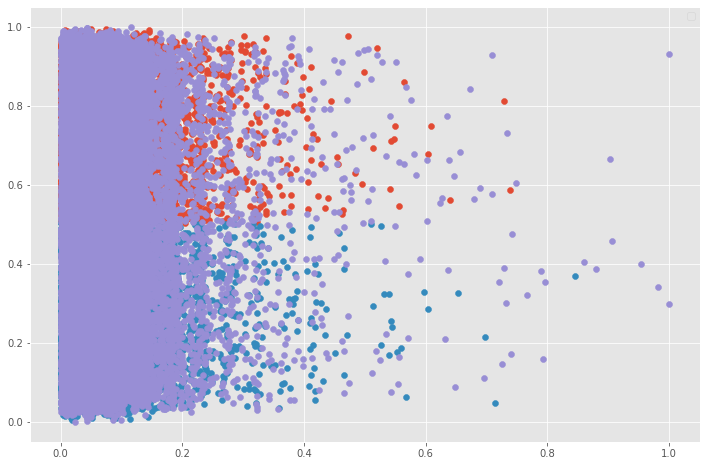

In [75]:
u_labels = np.unique(y_pred)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(kmeans_df[y_pred==i]['duration'],kmeans_df[y_pred==i]['total_data'])
plt.legend()
plt.show()

No handles with labels found to put in legend.


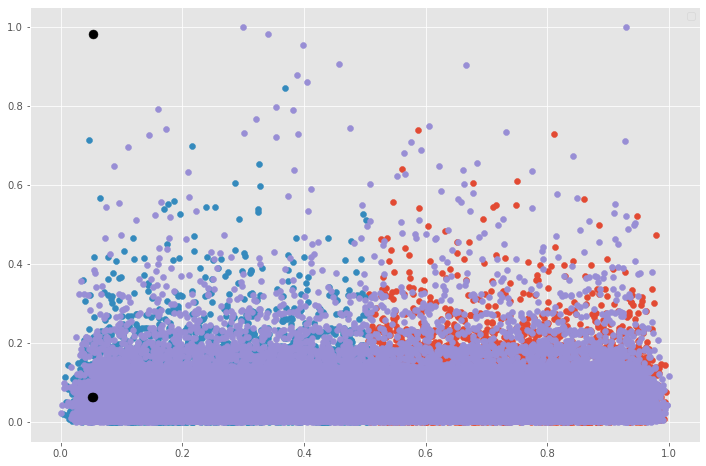

In [76]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(y_pred)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(kmeans_df[y_pred==i]['total_data'],kmeans_df[y_pred==i]['duration'])
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [82]:
def handle_missing_values_numeric(df, features):
        """
        this algorithm does the following
        - remove columns with x percentage of missing values
        - fill the missing values with the mean
        returns:
            - df
            - percentage of missing values
        """
        missing_percentage = round((df.isnull().sum().sum()/\
                reduce(lambda x, y: x*y, df.shape))*100,2)
        for key in features:
            df[key] = df[key].fillna(df[key].mean())
        return missing_percentage,df

In [84]:
_,df_to_transform = handle_missing_values_numeric(df_to_transform,df_to_transform.columns)

In [88]:
pca = PCA(2)


#Transform the data
df_ = pca.fit_transform(df_to_transform)
 
df_.shape

(150001, 2)

In [90]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
y_pred = kmeans.fit_predict(df_)

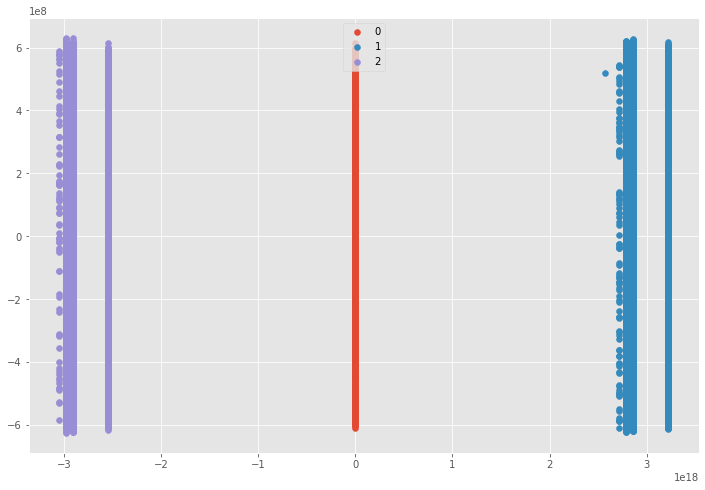

In [100]:
labels_ = np.unique(y_pred)
 
#plotting the results:
 
for i in labels_:
    plt.scatter(df_[y_pred == i , 0] , df_[y_pred == i , 1] , label = i)
plt.legend()
plt.show()

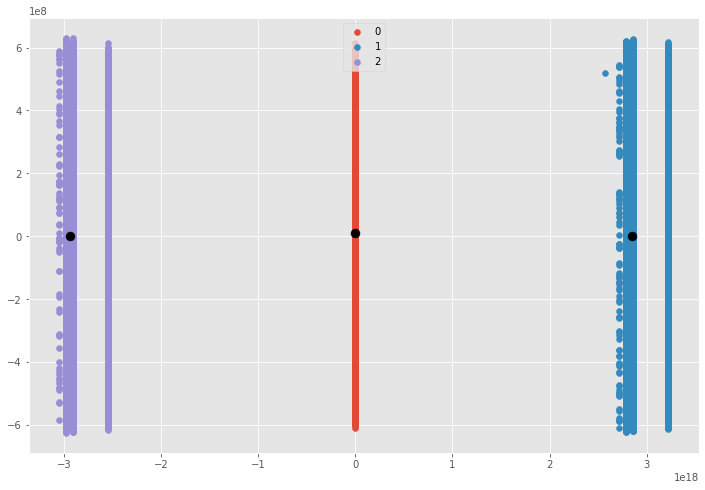

In [98]:
centroids = kmeans.cluster_centers_
labels_ = np.unique(y_pred)
 
#plotting the results:
 
for i in labels_:
    plt.scatter(df_[y_pred == i , 0] , df_[y_pred == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()


In [101]:
# Aggregate user total traffic per application and 
# derive the top 10 most engaged users per application

In [104]:
social_media_aggregation = aggregation_cols(app_df,'cus','social_media_data')
top_customers_social_media = social_media_aggregation.sort_values(by='social_media_data_max', ascending=False)
top_customers_social_media.head(10)

,social_media_data_min,social_media_data_max,social_media_data_mean
total_data,,,
202861272.0,3650861.0,3650861.0,3650861.0
537130735.0,3650240.0,3650240.0,3650240.0
155655066.0,3648814.0,3648814.0,3648814.0
811819225.0,3648729.0,3648729.0,3648729.0
283278175.0,3648659.0,3648659.0,3648659.0
519661021.0,3648092.0,3648092.0,3648092.0
563495349.0,3648027.0,3648027.0,3648027.0
813276111.0,3647700.0,3647700.0,3647700.0
215871906.0,3647486.0,3647486.0,3647486.0
